# Data Preprocessing

In this section, we will attempt to clean the following datasets:
   - TLC Yellow Taxi Trips Record 2021/10-2022/04
   - TLC Green Taxi Trips Record 2021/10-2022/04

***

## Import Libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

%matplotlib inline
sns.set(style='whitegrid', palette='pastel', color_codes=True)
sns.mpl.rc('figure', figsize=(10,6))


## Inspect the dataset

In [2]:
# Starting a Spark session
spk = (
    SparkSession.builder.appName('Playground')
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

# Read the parquet dataset
df = spk.read.parquet('/Users/oliver/Downloads/MAST30034_Python-main/data/tlc_data')


In [3]:
# Inspect the metadata
df.printSchema()

print("Number of instances: ", df.count(), '\n',
      "Number of features: ", len(df.columns))


root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)

Number of instances:  22821986 
 Number of features:  19


In [4]:
# Make all variable names consistent
column_name = {'VendorID': 'vendor_id', 
               'RatecodeID': 'rate_code_id', 
               'PULocationID': 'pu_location_id',
               'DOLocationID': 'do_location_id'}

for key, value in column_name.items():
    df = df.withColumnRenamed(key,value)
    

In [5]:
# Check variable names
df.columns


['vendor_id',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'rate_code_id',
 'store_and_fwd_flag',
 'pu_location_id',
 'do_location_id',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee']

## Check for outliers in the data based on each feature

In [6]:
# Extract trip duration in minutes
df = df.withColumn('trip_duration_min',
                   (func.col('tpep_dropoff_datetime').cast('long') - 
                    func.col('tpep_pickup_datetime').cast('long')) / 60)

# Extract the date as a standalone feature
df = df.withColumn("pickup_date", 
                   func.to_date(func.col("tpep_pickup_datetime")))

df = df.withColumn("dropoff_date",
                   func.to_date(func.col("tpep_dropoff_datetime")))


In [7]:
# Check earliest and latest of datetime variables
print("tpep_pickup_datetime:\n\tMax:", df.agg({"tpep_pickup_datetime": "max"}).collect()[0][0],
     "\n\tMin:", df.agg({"tpep_pickup_datetime": "min"}).collect()[0][0])

print("\ntpep_dropoff_datetime:\n\tMax:", df.agg({"tpep_dropoff_datetime": "max"}).collect()[0][0],
     "\n\tMin:", df.agg({"tpep_dropoff_datetime": "min"}).collect()[0][0], '\n')

# Check other variables
df.select(['passenger_count',
           'trip_distance',
           'trip_duration_min',
           'fare_amount',
           'extra',
           'mta_tax',
           'tip_amount',
           'tolls_amount',
           'improvement_surcharge',
           'total_amount',
           'congestion_surcharge',
           'airport_fee']).describe().show(vertical=True)


tpep_pickup_datetime:
	Max: 2028-12-07 15:48:15 
	Min: 2003-01-01 11:10:06

tpep_dropoff_datetime:
	Max: 2028-12-07 16:29:13 
	Min: 2003-01-01 11:38:46 

-RECORD 0------------------------------------
 summary               | count               
 passenger_count       | 22045834            
 trip_distance         | 22821986            
 trip_duration_min     | 22821986            
 fare_amount           | 22821986            
 extra                 | 22821986            
 mta_tax               | 22821986            
 tip_amount            | 22821986            
 tolls_amount          | 22821986            
 improvement_surcharge | 22821986            
 total_amount          | 22821986            
 congestion_surcharge  | 22045834            
 airport_fee           | 22045834            
-RECORD 1------------------------------------
 summary               | mean                
 passenger_count       | 1.410832132728569   
 trip_distance         | 6.379380374258177   
 trip_duration_min

Despite having retrieved the data from 2021-10 to 2022-04, the dataset still contains records from previous years. The numerical features such as `trip_distance`, `fare_amount`, `tolls_amount`, `total_amount`, `trip_duration` also contain unrealistic values which need to be removed.

## Data Cleaning

To clean the code, we need to first consider the minimum possible and logical value for each column:
- `extra`, `mta_tax`, `tip_amount`, `tolls_amount`, `improvement_surcharge`, `congestion_surcharge` and `airport_fee` can take value greater or equal to 0.
- `passenger_count` must take value greater or equal to 1.
- We assume that the minimum `trip_distance` and `trip_duration_min` for a regular ride is atleast 0.5 miles and 1 min respectively.
- Based on the TLC website, the initial fare of each ride is \$2.5 so we assume that minimum `fare_amount` is \$2.5

In [8]:
# Filter based on the minimum possible values for numerical features
df1 = df.where((func.col('passenger_count') > 0) &
               (func.col('trip_distance') > 0.5) &
               (func.col('trip_duration_min') > 1) &
               (func.col('fare_amount') >= 2.50) &
               (func.col('extra') >= 0) &
               (func.col('mta_tax') >= 0) &
               (func.col('tip_amount') >= 0) &
               (func.col('tolls_amount') >= 0) &
               (func.col('improvement_surcharge') >= 0) &
               (func.col('total_amount') >= 0) &
               (func.col('congestion_surcharge') >= 0) &
               (func.col('airport_fee') >= 0))


Since the dataset is too large, it is not feasible to check the outlier individually for each numerical column. So instead, we looked at the 99.99th percentile of the data and decide if the value is logical and possible.

We also capped the `trip_duration_min` to atmost 5 hours (300 mins).

In [9]:
# Filter the columns to cover 99.99 percentile of the data for numerical features
df1 = df1.where((func.col('fare_amount') <= df1.selectExpr('percentile(fare_amount, 0.9999)').collect()[0][0]) &
                (func.col('trip_distance') <= df1.selectExpr('percentile(trip_distance, 0.9999)').collect()[0][0]) &
                (func.col('tip_amount') <= df1.selectExpr('percentile(tip_amount, 0.9999)').collect()[0][0]) &
                (func.col('total_amount') <= df1.selectExpr('percentile(total_amount, 0.9999)').collect()[0][0]) &
                (func.col('tolls_amount') <= df1.selectExpr('percentile(tolls_amount, 0.9999)').collect()[0][0]) &
                (func.col('trip_duration_min') <= 300))


In [10]:
# Filter the period to between 2021-10 to 2022-04
df1 = df1.where((func.col("pickup_date") >= '2021-10-01') & 
                (func.col("dropoff_date") >= '2021-10-01') &
                (func.col("pickup_date") <= '2022-04-30') & 
                (func.col("dropoff_date") <= '2022-04-30'))


In [11]:
# Check the descriptive statistics of all numerical columns
df1.select(['passenger_count',
           'trip_distance',
           'trip_duration_min',
           'fare_amount',
           'extra',
           'mta_tax',
           'tip_amount',
           'tolls_amount',
           'improvement_surcharge',
           'total_amount',
           'congestion_surcharge',
           'airport_fee',
           'pickup_date']).describe()


summary,passenger_count,trip_distance,trip_duration_min,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
count,20318397,20318397,20318397,20318397,20318397,20318397,20318397,20318397,20318397,20318397,20318397,20318397
mean,1.4471206070045781,3.395187665639183,15.1713447784948,13.877776812315647,1.026717178033286,0.4978357894079938,2.6138943894049658,0.4652825486201695,0.29998945784806097,20.52600121405045,2.343431364196693,0.08641983420247178
stddev,0.9877491531253714,4.1658235930528695,11.5078125190917,11.702891141665209,1.2360292896413865,0.033540865546170986,2.7895050467472773,1.811713249822163,0.001778353195422...,14.913934539512917,0.605727538981753,0.31710630703053033
min,1.0,0.51,1.0166666666666666,2.5,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
max,9.0,57.3,299.9166666666667,200.0,33.5,17.1,50.0,25.8,0.3,231.85,2.75,1.25


In [22]:
# Check period of data
pu_earliest, pu_latest = df1.select(func.min("pickup_date"), func.max("pickup_date")).first()
do_earliest, do_latest = df1.select(func.min("dropoff_date"), func.max("dropoff_date")).first()

print(f"pickup_date: {pu_earliest} - {pu_latest}")
print(f"dropoff_date: {do_earliest} - {do_latest}")


pickup_date: 2021-10-01 - 2022-04-30
dropoff_date: 2021-10-01 - 2022-04-30


The dataset looks much cleaner now and easier to work with. In the following parts, we will begin feature engineering to facilitate our analysis later on.

## Feature Engineering

## Extract hourly pickup and dropoff demand in each location id

We first create columns to record date and hour. Then we group by `pu_location_id`/`do_location_id`, `date` and `hour` before counting the number of instances.

In [69]:
# Create columns for date and hour
df1 = (df1
  .withColumn("pickup_date", func.col("tpep_pickup_datetime").cast("date"))
  .withColumn("pickup_hour", func.hour(func.col("tpep_pickup_datetime")))
  .withColumn("dropoff_date", func.col("tpep_dropoff_datetime").cast("date"))
  .withColumn("dropoff_hour", func.hour(func.col("tpep_dropoff_datetime")))
)


In [71]:
# Aggregate and count number of hourly instances in each location id
pickup_hourly_demand = df1.groupBy("pu_location_id", "pickup_date", "pickup_hour").count()
dropoff_hourly_demand = df1.groupBy("do_location_id", "dropoff_date", "dropoff_hour").count()


In [97]:
# Aggregate and count number of daily instances in each location id
pickup_daily_demand = df1.groupBy("pu_location_id", "pickup_date").count()
dropoff_daily_demand = df1.groupBy("do_location_id", "dropoff_date").count()


In [98]:
pickup_daily_demand.describe()


summary,pu_location_id,count
count,41090,41090
mean,136.1556826478462,494.4852032124605
stddev,76.72277128104115,1023.0618719773645
min,1,1
max,265,6907


In [99]:
dropoff_daily_demand.describe()


summary,do_location_id,count
count,52355,52355
mean,133.79742144971826,388.0889504345335
stddev,76.92595418182918,803.9522842386245
min,1,1
max,265,5984


It appears that the average daily pickup demand is about 494 with maximum number of pickup per hour at 6907. However, since demand is strongly based on `LocationID` which explains the large standard deviation at 1023.1, we need to examine the demand statistics based on individual location to make a legitimate inference. 

In [100]:
operations = [func.mean, func.stddev, func.min, func.max]
exprs = [f(func.col("count")) for f in operations]
# location_hourly_statistics = pickup_hourly_demand.groupby('pu_location_id').agg(*exprs)
location_daily_statistics = pickup_daily_demand.groupby('pu_location_id').agg(*exprs)

In [101]:
location_daily_statistics.sort(func.col("stddev_samp(count)").desc())

pu_location_id,avg(count),stddev_samp(count),min(count),max(count)
237,4683.061320754717,1307.846125931082,762,6907
161,3828.9292452830186,1120.9565734317307,526,5854
79,2544.7971698113206,1117.1535517515056,758,5331
236,4235.278301886792,1107.4944621948969,779,6051
132,3939.3490566037735,892.9362878027387,420,5887
162,3157.627358490566,865.726562682048,562,4790
138,2717.8632075471696,713.2700047545486,50,4373
249,2105.0707547169814,671.2235765799452,631,3763
163,2783.9150943396226,666.7183495943195,550,3979
142,3225.2216981132074,664.099813274643,1036,4552


Here we notice that most of the locations with high standard deviations are located at city center. We hypothesize that this is due to the confounding effects of day in the week (more crowded in the city during weekends and public holidays) as well as weather of the day.

In [61]:
half_manhattan_id = [144, 148, 151, 152, 153, 158, 161,
       162, 163, 164, 166, 170, 186, 194, 202, 209, 211, 224, 229, 230,
       231, 232, 233, 234, 236, 237, 238, 239, 243, 244, 246, 249, 261,
       262, 263]

half_manhattan_id_2 = [4,  12,  13,  24,  41,  42,  43,  45,  48,  50,  68,  74,  75,
        79,  87,  88,  90, 100, 103, 107, 113, 114, 116, 120, 125, 127,
       128, 137, 140, 141, 142, 143, 144]

In [63]:
one_day_wtc_pickup_demand = aggs_pickup.where((func.col('pu_location_id').isin(half_manhattan_id_2)) & 
                                              (func.col('date') == '2022-03-19')).toPandas()

one_day_wtc_dropoff_demand = aggs_dropoff.where((func.col('do_location_id').isin(half_manhattan_id_2)) & 
                                                (func.col('date') == '2022-03-19')).toPandas()

In [55]:
one_day_cp_pickup_demand = aggs_pickup.where((func.col('pu_location_id') == 43) & 
                                              (func.col('date') == '2022-03-19')).toPandas()

one_day_cp_dropoff_demand = aggs_dropoff.where((func.col('do_location_id') == 43) & 
                                                (func.col('date') == '2022-03-19')).toPandas()

In [56]:
one_day_cp_pickup_demand

,pu_location_id,date,hour,count
0,43,2022-03-19,2,4
1,43,2022-03-19,0,18
2,43,2022-03-19,16,182
3,43,2022-03-19,7,11
4,43,2022-03-19,15,187
5,43,2022-03-19,22,49
6,43,2022-03-19,8,26
7,43,2022-03-19,19,104
8,43,2022-03-19,10,80
9,43,2022-03-19,21,66


In [66]:
df2 = one_day_wtc_pickup_demand.groupby('hour').agg({'count':'sum'}).reset_index()
df3 = one_day_wtc_dropoff_demand.groupby('hour').agg({'count':'sum'}).reset_index()

In [58]:
df_cp_pu = one_day_cp_pickup_demand.groupby('hour').agg({'count':'sum'}).reset_index()
df_cp_do = one_day_cp_dropoff_demand.groupby('hour').agg({'count':'sum'}).reset_index()

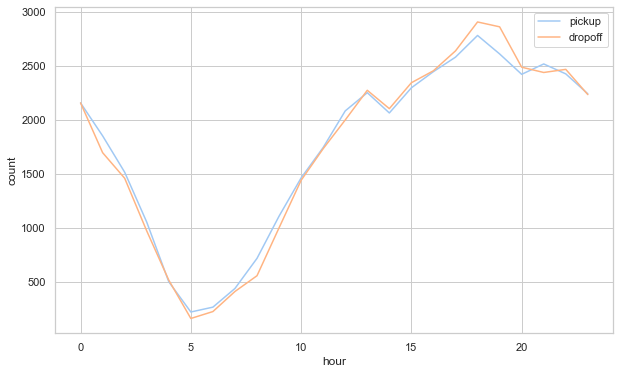

In [67]:
fig, ax = plt.subplots()
sns.lineplot(x='hour', y='count', data=df2, ax=ax)
sns.lineplot(x='hour', y='count', data=df3, ax=ax)
ax.legend(['pickup','dropoff'])

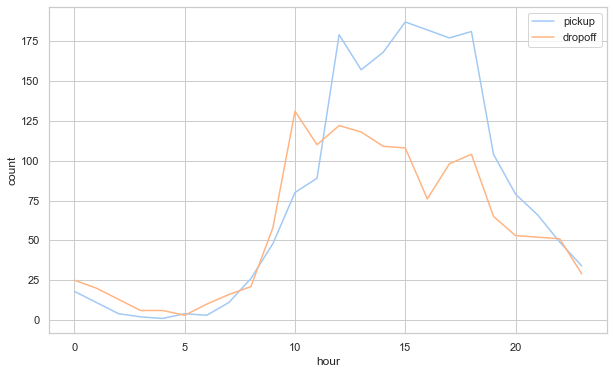

In [60]:
fig, ax = plt.subplots()
sns.lineplot(x='hour', y='count', data=df_cp_pu, ax=ax)
sns.lineplot(x='hour', y='count', data=df_cp_do, ax=ax)
ax.legend(['pickup','dropoff'])

In [ ]:
sns.lineplot('hour', 'count', data=one_day_wtc_dropoff_demand)